In [1]:
from koopman_probabilistic import *
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

from scipy.stats import norm

In [2]:
x = np.transpose(np.load("FPUT.npy"))
x.shape

(10000, 40)

In [2]:
x = np.load("energy_data.npy")

In [ ]:
import json

with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2005-2015.json") as f:
    all_data = json.loads(f.read())
    
x = np.transpose(np.array([all_data["ISONE CA"]["DEMAND"], all_data["ISONE CA"]["DewPnt"], all_data["ISONE CA"]["DryBulb"]], dtype=np.float64))

In [4]:
mean = np.mean(x, axis=0)
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = (x - np.matlib.repmat(mean, x.shape[0], 1)) / np.matlib.repmat(rnge, x.shape[0], 1)

In [9]:
data_name = "energy_data"

predict_through = x.shape[0]
train_through = 5 * 365 * 24 // 2
xt = x[:train_through, :]

num_freqs = [5, 5, 5]
num_fourier = 2
mu_file = "forecasts//" + data_name + f"trainedThrough{train_through}_{num_freqs}mu.npy"
sigma_file = "forecasts//" + data_name + f"trainedThrough{train_through}_{num_freqs}sigma.npy"
alpha_file = "forecasts//" + data_name + f"trainedThrough{train_through}_{num_freqs}alpha.npy"

In [10]:
model = SkewNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=512)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier)
k.find_fourier_omegas(xt)

fourier periods: tensor([ 24.0132, 168.4615], dtype=torch.float64)


tensor([0.2617, 0.0373], dtype=torch.float64)

In [11]:
k.fit(xt, iterations=30, interval=10, verbose=True, cutoff=0, weight_decay=1e-1000, lr_theta=5e-3, lr_omega=1e-8)
mu_hat, sigma_hat, a_hat = k.predict(predict_through)
np.save(mu_file, mu_hat)
np.save(sigma_file, sigma_hat)
np.save(alpha_file, a_hat)

Iteration  0
tensor([ 24.0132, 168.4615,  78.5398,  54.6364,  41.8879,  24.0132, 168.4615,
         24.6399,  21.6662,  19.3329,  24.0132, 168.4615,  14.6121,  13.5122,
         12.5664])
Setting periods to tensor([ 24.0132, 168.4615,  78.5398,  54.6364,  41.8879,  24.0132, 168.4615,
         24.6399,  21.6662,  19.3329,  24.0132, 168.4615,  14.6121,  13.5122,
         12.5664], grad_fn=<MulBackward0>)
Loss:  7.161561235317475
Iteration  1
tensor([ 24.0132, 168.4615,  78.5398,  54.6364,  41.8879,  24.0132, 168.4615,
         24.6399,  21.6662,  19.3329,  24.0132, 168.4615,  14.6121,  13.5122,
         12.5664])
Setting periods to tensor([ 24.0132, 168.4615,  78.5398,  54.6364,  41.8879,  24.0132, 168.4615,
         24.6399,  21.6662,  19.3329,  24.0132, 168.4615,  14.6121,  13.5122,
         12.5664], grad_fn=<MulBackward0>)
Loss:  7.161560931441749
Iteration  2
tensor([ 24.0132, 168.4615,  78.5398,  54.6364,  41.8879,  24.0132, 168.4615,
         24.6399,  21.6662,  19.3329,  24.0132,

Setting periods to tensor([ 24.0132, 168.4616,  78.5398,  54.6364,  41.8879,  24.0132, 168.4615,
         24.6399,  21.6662,  19.3329,  24.0132, 168.4614,  14.6121,  13.5122,
         12.5664], grad_fn=<MulBackward0>)
Loss:  2.9475283945160378
Iteration  20
tensor([ 24.0132, 168.4616,  78.5398,  54.6364,  41.8879,  24.0132, 168.4615,
         24.6399,  21.6662,  19.3329,  24.0132, 168.4614,  14.6121,  13.5122,
         12.5664])
Setting periods to tensor([ 24.0132, 168.4617,  78.5398,  54.6364,  41.8879,  24.0132, 168.4615,
         24.6399,  21.6662,  19.3329,  24.0132, 168.4612,  14.6121,  13.5122,
         12.5664], grad_fn=<MulBackward0>)
Loss:  2.7314043726970794
Iteration  21
tensor([ 24.0132, 168.4617,  78.5398,  54.6364,  41.8879,  24.0132, 168.4615,
         24.6399,  21.6662,  19.3329,  24.0132, 168.4612,  14.6121,  13.5122,
         12.5664])
Setting periods to tensor([ 24.0132, 168.4618,  78.5398,  54.6364,  41.8879,  24.0132, 168.4615,
         24.6399,  21.6662,  19.3329,

<IPython.core.display.Javascript object>


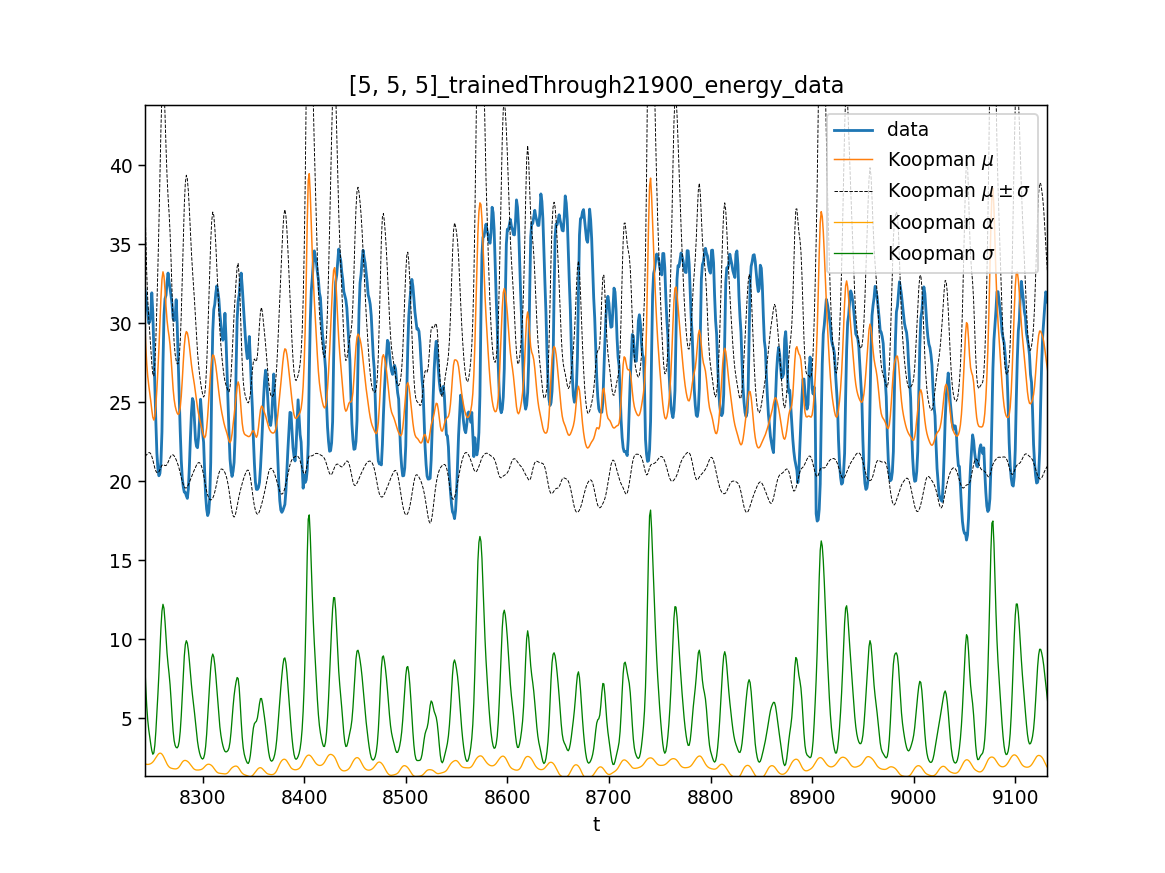

In [12]:
%matplotlib notebook

mean_hat = model.mean(mu_hat, sigma_hat, a_hat)
std_hat = model.std(mu_hat, sigma_hat, a_hat)
for dim in range(xt.shape[1]):
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman $\mu$", linewidth=0.8)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman $\mu \pm \sigma$ ", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    plt.plot(a_hat[:, dim], color="orange", linewidth=0.7, label="Koopman $\\alpha$")
    plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman $\sigma$")

    # plt.plot(mu_vec[slc:], label="real mu")
    # plt.plot(mu_hat[slc:, 0], label="koopman mu")
    # plt.legend()
    # plt.show()
    #
    # plt.plot(sigma_vec[slc:], label="real sigma")
    #     plt.plot(3*sigma_hat[:, dim], label="koopman $3\sigma$", linewidth=0.7)
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [139]:
k.omegas[7] = 2*np.pi / 5500

In [156]:
mu_hat = np.load("forecasts//energy_data_4mu.npy")
sigma_hat = np.load("forecasts//energy_data_4sigma.npy")

In [157]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

In [171]:
z_scores = ((x - mu_hat) / sigma_hat)[:8760, 0]
# z_scores /= np.std(z_scores)
z_hist, bin_edges = np.histogram(z_scores, bins=40, density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2

In [167]:
np.std(z_scores)

1.8403758604065568

<IPython.core.display.Javascript object>


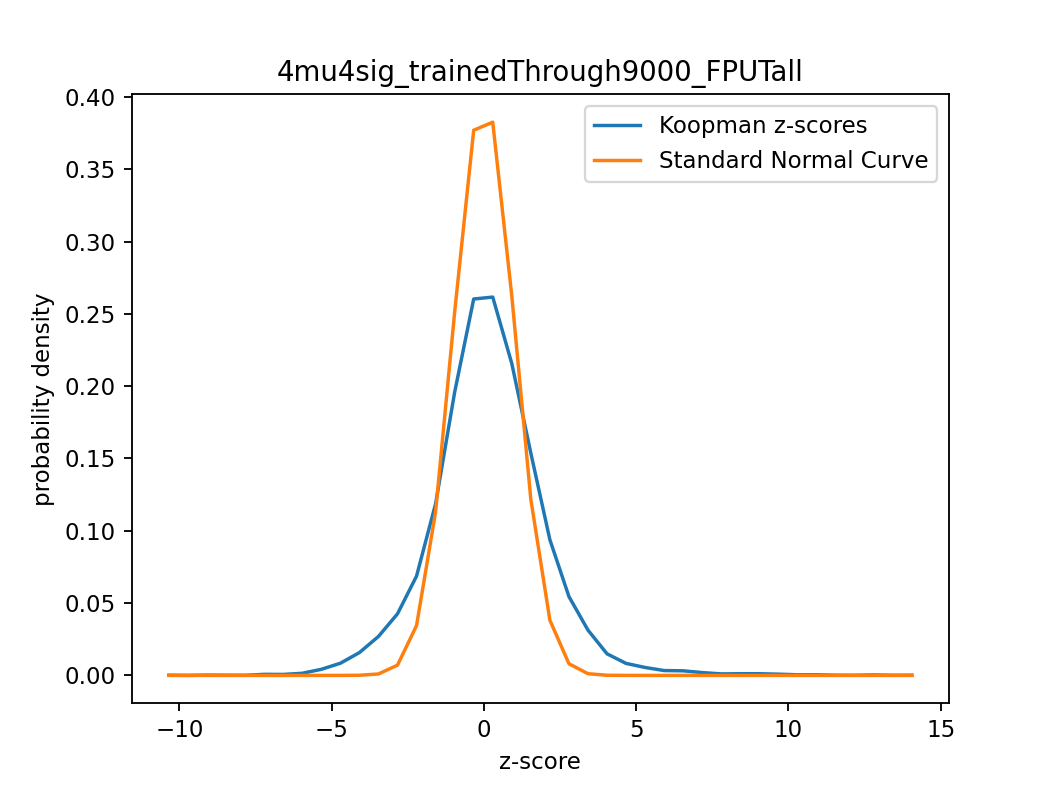

In [172]:
plt.figure()
plt.plot(z_axis, z_hist, label="Koopman z-scores")
plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
plt.title(f"{num_mu}mu{num_sig}sig_trainedThrough{train_through}_" + data_name)
plt.xlabel("z-score")
plt.ylabel("probability density")
plt.legend()

AttributeError: module 'matplotlib.pyplot' has no attribute 'gf'

In [53]:
def pinball_loss(data, mus, sigmas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q/100
            if q == 0.5:
                print(quant_pred, data[i])
            quant_pred = mus[i] + sigmas[i] * norm.ppf(q)
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data))

mus = mu_hat[:, 0] * rnge[0] + mean[0]
sigmas = sigma_hat[:, 0] * rnge[0]
# x = x[train_through:train_through + 720, 0] * rnge[0] + mean[0]
print(rnge)
print(mean)

pinball_loss(x, mus[train_through:train_through + 720], sigmas[train_through:train_through + 720])

[1. 1. 1.]
[-1.4892390e-07  1.6343780e-07  4.0236596e-08]
-0.10909090163535332 -0.07769873
-0.12493122619691938 -0.115170985
-0.1455837600923926 -0.14069046
-0.1630066743194753 -0.1536015
-0.15627149104869179 -0.15546754
-0.10407337933172803 -0.1473477
-0.025391175676196344 -0.12883852
0.019551604395652063 -0.1086146
0.043586088506068 -0.07189885
0.05417401114292593 -0.029383212
0.06214927175495973 0.0017343982
0.06289374804351712 0.02014271
0.05960767688366102 0.03043119
0.05055307390318298 0.025589552
0.04260516284509087 0.017520156
0.014317857570094253 0.023067866
-0.04167043458150588 0.08303357
-0.12015573808656717 0.13967066
-0.16330072446091462 0.13165168
-0.17072211890167202 0.10971302
-0.15168676678728993 0.082226634
-0.12753689297206816 0.036886707
-0.10519731899729595 -0.018539961
-0.09655892630031354 -0.07749699
-0.10186549784616301 -0.123896025
-0.11730522129070231 -0.15087807
-0.13563267651030406 -0.16424301
-0.1497701807921461 -0.16747077
-0.13400523228431388 -0.15894747


0.07148294775985055 0.072240755
0.06077098174975052 0.062254876
0.04621745632565388 0.055950657
0.031053427652577383 0.04732649
0.0007779852578770827 0.047528226
-0.05818539629044843 0.090396896
-0.13197136040279372 0.16619879
-0.18224983062354372 0.16836745
-0.18579359827899938 0.14743744
-0.1656239964850176 0.1125373
-0.13703290143426686 0.0570602
-0.11255771361289965 -0.021969454
-0.0981479532576178 -0.09550183
-0.10258935624632429 -0.1408922
-0.1167349976615175 -0.16293173
-0.1365140962858471 -0.17211068
-0.15244078636799965 -0.17105156
-0.14784585551573393 -0.1551145
-0.09731173456316643 -0.09378709
-0.02111116193575037 0.020647047
0.022011725597503192 0.08716914
0.042537621248483724 0.094835065
0.050722174994432837 0.09377596
0.05622226510206686 0.09357422
0.053256117401863846 0.08868215
0.04417883125246406 0.07708239
0.03007304878686348 0.07143381
0.016834684248072336 0.06321312
-0.015116158689850695 0.065936536
-0.0772619100586186 0.1072922
-0.14861900709285758 0.15207735
-0.18

0.07131070590379898 0.101694055
0.09436846161300436 0.12711266
0.1054234400540593 0.14652964
0.10936034496410478 0.16312234
0.11085980569546278 0.16766137
0.1080911208788767 0.15898676
0.10081384533595134 0.15157302
0.09066361854528888 0.14027585
0.06398956364805944 0.13311426
0.006969343088155812 0.16367711
-0.070329482049979 0.23070353
-0.1318647739075089 0.22898878
-0.1483347964079586 0.19837551
-0.13537638000174368 0.15273298
-0.11245199665161917 0.08479875
-0.09191555631739406 0.002339603
-0.08275943202733252 -0.06892326
-0.08637605328017668 -0.11365797
-0.09955426989184765 -0.13519318
-0.11614504573136533 -0.14336345
-0.12361245024269363 -0.14205217
-0.0999955131468685 -0.12374472
-0.02423024390014457 -0.062366873
0.0534282575315554 0.05368114
0.0971672058680639 0.11379815
0.1178582766549709 0.1158155
0.12725960686279053 0.11142776
0.1277820272780262 0.10825044
0.12750409607077742 0.099626265
0.12160008727488954 0.087017834
0.11176504889058304 0.08025972
0.09782894380884047 0.070

0.30454576913199305

In [ ]:
plt.figure()
plt.plot(mu_vec, label="real $\mu$")
plt.plot(mu_hat[:, 0], "--", label="koopman $\mu$")
plt.xlabel("t")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


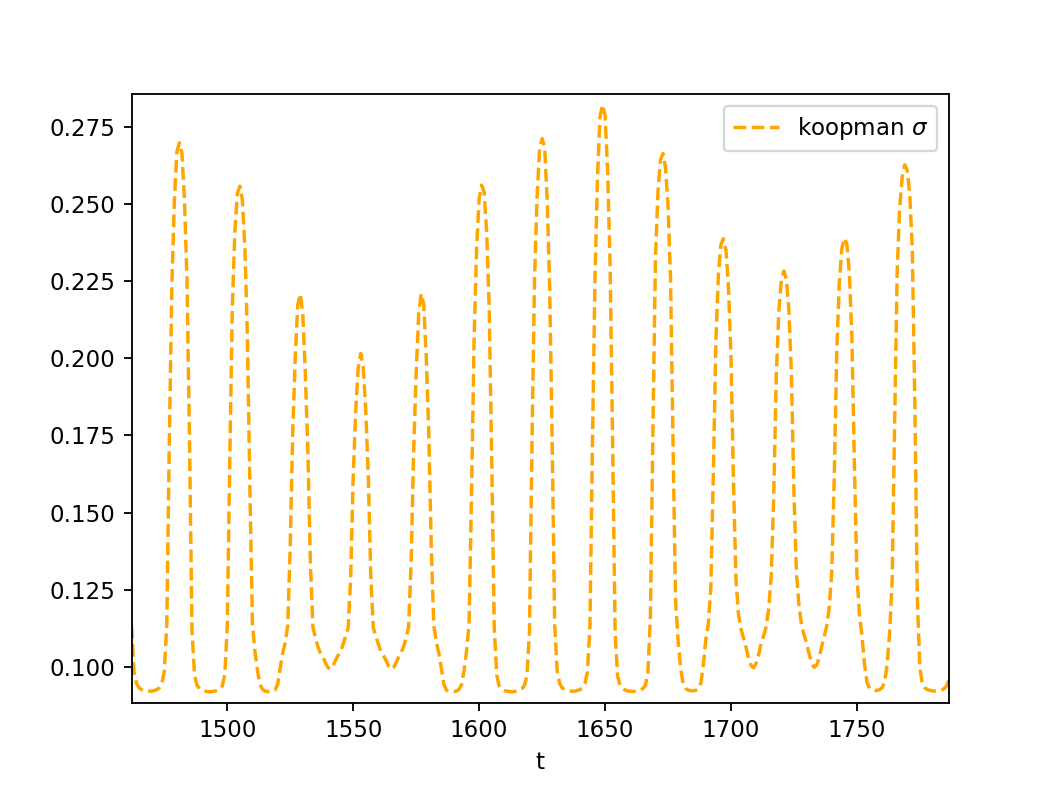

In [13]:
plt.figure()
# plt.plot(sigma_vec, color="blue", label="real $\sigma$")
plt.plot(sigma_hat[:, 0], "--", color="orange", label="koopman $\sigma$")
plt.xlabel("t")
plt.legend()
plt.show()

In [8]:
# Construct pdf quantiles
# REMOVE
# sigma = 1 * np.cos(2 * np.pi / 36 * np.arange(5000) + 1.5) + 4

num_quantiles = 100
domain = [min(mu_hat[:,0] - 2.5*sigma_hat[:, 0]), max(mu_hat[:,0] + 2.5*sigma_hat[:, 0])]
x_axis = np.linspace(domain[0], domain[1], num_quantiles)

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors

<IPython.core.display.Javascript object>


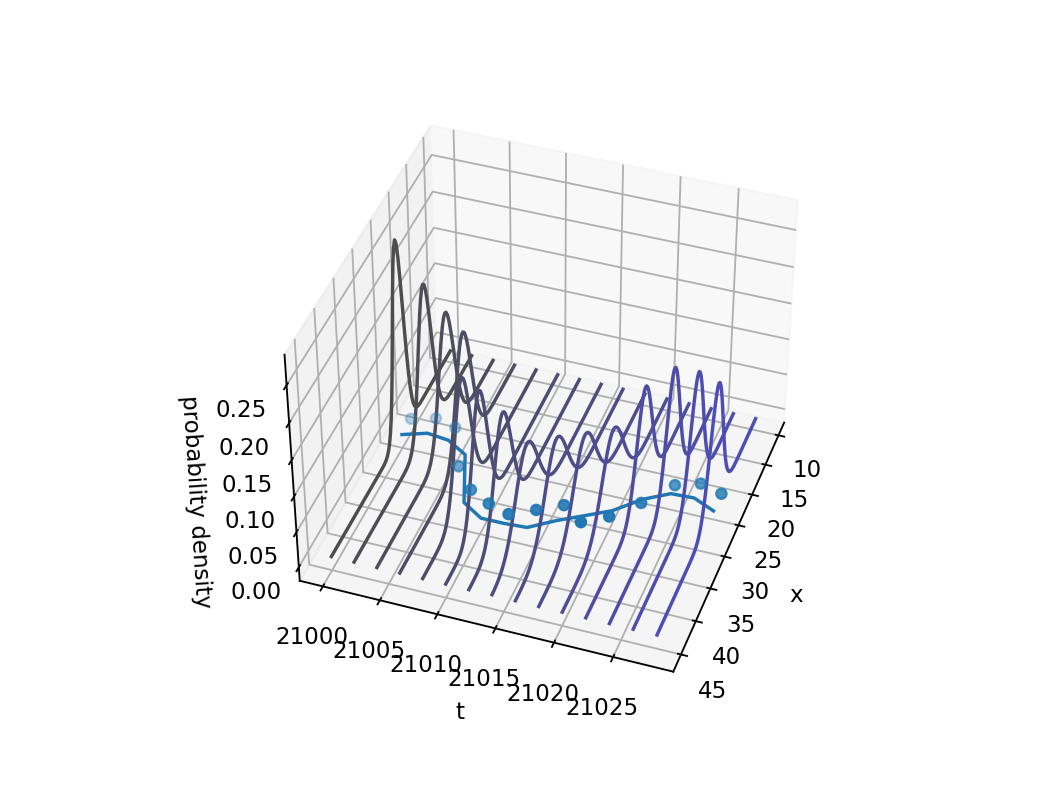

In [13]:
fig = plt.figure()
ax = fig.gca(projection='3d')

tmin = 21000
tmax = 21030
tstep = 2
ts = range(tmin, tmax, tstep)
plt.plot(mu_hat[tmin:tmax:tstep, 0], ts, np.zeros(len(ts)))
ax.scatter(x[tmin:tmax:tstep, 0], ts, np.zeros(len(ts)))

for i, t in enumerate(ts):
    z = normal_pdf(mu_hat[t], sigma_hat[t], x_axis)
    plt.plot(x_axis, t*np.ones(num_quantiles), z, color=(0.3, 0.3, 0.3 + 0.03*i))

plt.xlabel("x")
plt.ylabel("t")
ax.set_zlabel("probability density")


plt.show()

In [6]:
help(np.concatenate)

Help on function concatenate in module numpy:

concatenate(...)
    concatenate((a1, a2, ...), axis=0, out=None)
    
    Join a sequence of arrays along an existing axis.
    
    Parameters
    ----------
    a1, a2, ... : sequence of array_like
        The arrays must have the same shape, except in the dimension
        corresponding to `axis` (the first, by default).
    axis : int, optional
        The axis along which the arrays will be joined.  If axis is None,
        arrays are flattened before use.  Default is 0.
    out : ndarray, optional
        If provided, the destination to place the result. The shape must be
        correct, matching that of what concatenate would have returned if no
        out argument were specified.
    
    Returns
    -------
    res : ndarray
        The concatenated array.
    
    See Also
    --------
    ma.concatenate : Concatenate function that preserves input masks.
    array_split : Split an array into multiple sub-arrays of equal or
   